In [113]:
#v3.classification
#28/11/2018

dataname="crib_PL"
ignore_index = -1 #Unet has the possibility of masking out pixels in the output image, we can specify the index value here (though not used)
gpuid=1

# --- unet params
#these parameters get fed directly into the UNET class, and more description of them can be discovered there
n_classes= 2    #number of classes in the data mask that we'll aim to predict
in_channels= 3  #input channel of the data, RGB = 3
padding= True   #should levels be padded
depth= 5       #depth of the network 
wf= 2           #wf (int): number of filters in the first layer is 2**wf, was 6
up_mode= 'upconv' #should we simply upsample the mask, or should we try and learn an interpolation 
batch_norm = True #should we use batch normalization between the layers

# --- training params
batch_size=50
patch_size=512
num_epochs = 500
edge_weight = 1.0 #edges tend to be the most poorly segmented given how little area they occupy in the training set, this paramter boosts their values along the lines of the original UNET paper
phases = ["train","val"] #how many phases did we create databases for?
validation_phases= ["val"] #when should we do valiation? note that validation is time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch

In [114]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import DenseNet, ResNet, SqueezeNet

import torchvision.models as models

import PIL
import matplotlib.pyplot as plt
import cv2

import numpy as np
import sys, glob

from tensorboardX import SummaryWriter

import scipy.ndimage 

import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix
from sklearn import model_selection

from tqdm.autonotebook import tqdm
from unet import UNet

import os
    
#os.environ['PATH'] = 'C:\\research\\openslide\\bin' + ';' + os.environ['PATH'] #can either specify openslide bin path in PATH, or add it dynamically
import openslide
sys.path.insert(1,'/mnt/data/home/pjl54/WSI_handling')
import wsi

import albumentations as albu
from albumentations.pytorch import ToTensor

In [115]:
#helper function for pretty printing of current time and remaining time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [116]:
#specify if we should use a GPU (cuda) or only the CPU
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='GeForce GTX TITAN X', major=5, minor=2, total_memory=12212MB, multi_processor_count=24)


In [117]:
#build the model according to the paramters specified above and copy it to the GPU. finally print out the number of trainable parameters
 
# model = DenseNet(growth_rate=growth_rate, block_config=block_config,
#                  num_init_features=num_init_features, 
#                  bn_size=bn_size, 
#                  drop_rate=drop_rate, 
#                  num_classes=num_classes).to(device)


#model =  models.mobilenet_v2(pretrained=True).to(device)

model = UNet(n_classes=n_classes, in_channels=in_channels, padding=padding,depth=depth,wf=wf, up_mode=up_mode, batch_norm=batch_norm).to(device)
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")
#model.classifier=nn.Sequential( nn.Dropout(.2), nn.Linear(1280, num_classes))

# model = models.resnet50(pretrained=False)
# model.fc = nn.Linear(2048,num_classes,bias=True)
# model = model.to(device)


#model = DenseNet(growth_rate=32, block_config=(6, 12, 24, 16), #these represent the default parameters
#                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=3)

total params: 	122466


In [118]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,transforms=None , edge_weight= False):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname
        self.edge_weight = edge_weight
        
        self.transforms=transforms

        self.tables=tables.open_file(self.fname)
        self.numpixels=self.tables.root.numpixels[:]
        self.nitems=self.tables.root.img.shape[0]
        self.tables.close()
        
        self.img = None
        self.mask = None
        self.table = tables.open_file(self.fname,'r', driver='H5FD_CORE')
        
    def __getitem__(self, index):        
            
        img = self.table.root.img[index,:,:,:]
        mask = self.table.root.mask[index,:,:]
        
        #the original Unet paper assignes increased weights to the edges of the annotated objects
        #their method is more sophistocated, but this one is faster, we simply dilate the mask and 
        #highlight all the pixels which were "added"
        if(self.edge_weight):
            weight = scipy.ndimage.morphology.binary_dilation(mask==1, iterations =2) & ~mask
        else: #otherwise the edge weight is all ones and thus has no affect
            weight = np.ones(mask.shape,dtype=mask.dtype)
        
        img_new = img
        mask_new = mask
        weight_new = weight
        
        
        if self.transforms:
            augmented = self.transforms(image=img, masks=[mask,weight])
            img_new = augmented['image']
            mask_new,weight_new = augmented['masks']

            return img_new, mask_new, weight_new
    def __len__(self):
        return self.nitems


In [119]:
transforms = albu.Compose([
        albu.ElasticTransform(alpha=4, sigma=2, alpha_affine=4, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, approximate=True, p=0.3),
        albu.RandomSizedCrop((patch_size,patch_size), patch_size,patch_size),
        albu.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=10, val_shift_limit=3, always_apply=False, p=0.7),
        albu.VerticalFlip(p=.5),
        albu.HorizontalFlip(p=.5),
#         albu.GaussianBlur(blur_limit=3,p=0.1),
        albu.RandomBrightnessContrast(brightness_limit=0.1,contrast_limit=0.1,p=0.5),
#         albu.RandomResizedCrop(patch_size,patch_size,scale=(0.97,1.03),ratio=(1,1),p=0.3),
#         albu.Rotate(p=0, border_mode=cv2.BORDER_CONSTANT,value=0), #these need to be in a reproducible order, first affine transforms and then color"
#         albu.RandomSizedCrop((patch_size,patch_size), patch_size,patch_size),
#         albu.GridDistortion(num_steps=3, distort_limit=0.2, interpolation=1, border_mode=4, value=None, mask_value=None, p=0.3),
        
        ToTensor()
    ])

In [120]:
dataset={}
dataLoader={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    
    dataset[phase]=Dataset(f"./{dataname}_{phase}.pytable", transforms= transforms ,edge_weight=edge_weight)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0, pin_memory=True) 


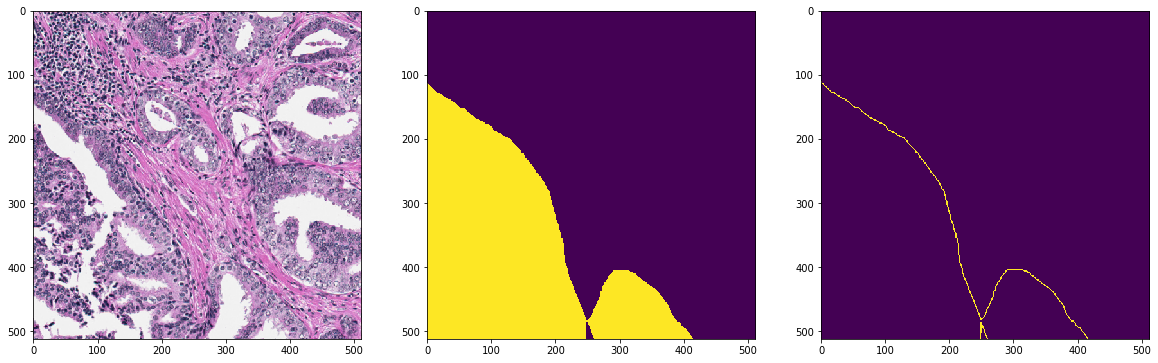

In [122]:
#visualize a single example to verify that it is correct
(img,patch_mask,patch_mask_weight)=dataset["train"][7]
fig, ax = plt.subplots(1,3, figsize=(20,8))  # 1 row, 2 columns

#build output showing original patch  (after augmentation), class = 1 mask, weighting mask, overall mask (to see any ignored classes)
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(patch_mask==1)
ax[2].imshow(patch_mask_weight)

In [123]:
optim = torch.optim.Adam(model.parameters()) #adam is going to be the most robust, though perhaps not the best performing, typically a good place to start
nclasses = dataset["train"].numpixels.shape[1]
class_weight=dataset["train"].numpixels[1,0:2] #don't take ignored class into account here
class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)

print(class_weight) #show final used weights, make sure that they're reasonable before continouing
criterion = nn.CrossEntropyLoss(weight = class_weight, ignore_index = ignore_index ,reduce=False) #reduce = False makes sure we get a 2D 

tensor([0.1819, 0.8181], device='cuda:1')


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [ ]:
writer=SummaryWriter() #open the tensorboard visualiser
best_loss_on_test = np.Infinity
edge_weight=torch.tensor(edge_weight).to(device)
start_time = time.time()
for epoch in range(num_epochs):
    #zero out epoch based performance variables 
    all_acc = {key: 0 for key in phases} 
    all_loss = {key: torch.zeros(0).to(device) for key in phases}
    cmatrix = {key: np.zeros((2,2)) for key in phases}

    for phase in phases: #iterate through both training and validation states

        if phase == 'train':
            model.train()  # Set model to training mode
        else: #when in eval mode, we don't want parameters to be updated
            model.eval()   # Set model to evaluate mode

        for ii , (X, y, y_weight) in enumerate(dataLoader[phase]): #for each of the batches
            X = X.to(device)  # [Nbatch, 3, H, W]
            y_weight = y_weight.type('torch.FloatTensor').to(device)
            y = y.type('torch.LongTensor').to(device)  # [Nbatch, H, W] with class indices (0, 1)

            with torch.set_grad_enabled(phase == 'train'): #dynamically set gradient computation, in case of validation, this isn't needed
                                                            #disabling is good practice and improves inference time

                prediction = model(X)  # [N, Nclass, H, W]
                loss_matrix = criterion(prediction, y)
                loss = (loss_matrix * (edge_weight**y_weight)).mean() #can skip if edge weight==1

                if phase=="train": #in case we're in train mode, need to do back propogation
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    train_loss = loss


                all_loss[phase]=torch.cat((all_loss[phase],loss.detach().view(1,-1)))

                if phase in validation_phases: #if this phase is part of validation, compute confusion matrix
                    p=prediction[:,:,:,:].detach().cpu().numpy()
                    cpredflat=np.argmax(p,axis=1).flatten()
                    yflat=y.cpu().numpy().flatten()
                    CM = scipy.sparse.coo_matrix((np.ones(yflat.shape[0], dtype=np.int64), (yflat, cpredflat)),
                            shape=(n_classes, n_classes), dtype=np.int64,
                            ).toarray()
                    cmatrix[phase]=cmatrix[phase]+CM
#                    cmatrix[phase]=cmatrix[phase]+confusion_matrix(yflat,cpredflat,labels=range(n_classes))

        all_acc[phase]=(cmatrix[phase]/cmatrix[phase].sum()).trace()
        all_loss[phase] = all_loss[phase].cpu().numpy().mean()

        #save metrics to tensorboard
        writer.add_scalar(f'{phase}/loss', all_loss[phase], epoch)
        if phase in validation_phases:
            writer.add_scalar(f'{phase}/acc', all_acc[phase], epoch)
            writer.add_scalar(f'{phase}/TN', cmatrix[phase][0,0], epoch)
            writer.add_scalar(f'{phase}/TP', cmatrix[phase][1,1], epoch)
            writer.add_scalar(f'{phase}/FP', cmatrix[phase][0,1], epoch)
            writer.add_scalar(f'{phase}/FN', cmatrix[phase][1,0], epoch)
            writer.add_scalar(f'{phase}/TNR', cmatrix[phase][0,0]/(cmatrix[phase][0,0]+cmatrix[phase][0,1]), epoch)
            writer.add_scalar(f'{phase}/TPR', cmatrix[phase][1,1]/(cmatrix[phase][1,1]+cmatrix[phase][1,0]), epoch)

    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
                                                 epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")    

    #if current loss is the best we've seen, save model state with all variables
    #necessary for recreation
    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict(),
         'best_loss_on_test': all_loss,
         'n_classes': n_classes,
         'in_channels': in_channels,
         'padding': padding,
         'depth': depth,
         'wf': wf,
         'up_mode': up_mode, 'batch_norm': batch_norm}


        torch.save(state, f"{dataname}_unet_best_model.pth")
    else:
        print("")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


1m 7s (- 556m 33s) ([1/500] 0%), train loss: 0.2528 test loss: 0.2659  **
2m 11s (- 543m 42s) ([2/500] 0%), train loss: 0.2140 test loss: 0.2469  **
3m 15s (- 540m 5s) ([3/500] 0%), train loss: 0.1981 test loss: 0.2339  **
4m 20s (- 536m 53s) ([4/500] 0%), train loss: 0.1891 test loss: 0.2194  **
5m 23s (- 533m 35s) ([5/500] 1%), train loss: 0.1735 test loss: 0.1981  **
6m 29s (- 534m 3s) ([6/500] 1%), train loss: 0.1668 test loss: 0.2802
7m 35s (- 533m 51s) ([7/500] 1%), train loss: 0.1585 test loss: 0.2064
8m 38s (- 530m 53s) ([8/500] 1%), train loss: 0.1499 test loss: 0.1815  **
9m 42s (- 529m 35s) ([9/500] 1%), train loss: 0.1447 test loss: 0.2104
10m 47s (- 528m 32s) ([10/500] 2%), train loss: 0.1454 test loss: 0.2052
11m 51s (- 527m 16s) ([11/500] 2%), train loss: 0.1383 test loss: 0.1692  **
12m 57s (- 526m 56s) ([12/500] 2%), train loss: 0.1349 test loss: 0.1712
14m 4s (- 527m 8s) ([13/500] 2%), train loss: 0.1352 test loss: 0.1815
15m 8s (- 525m 39s) ([14/500] 2%), train loss:

119m 45s (- 414m 52s) ([112/500] 22%), train loss: 0.0770 test loss: 0.1531
120m 50s (- 413m 48s) ([113/500] 22%), train loss: 0.0763 test loss: 0.1270
121m 53s (- 412m 42s) ([114/500] 22%), train loss: 0.0735 test loss: 0.1491
122m 58s (- 411m 40s) ([115/500] 23%), train loss: 0.0725 test loss: 0.1346
124m 1s (- 410m 33s) ([116/500] 23%), train loss: 0.0739 test loss: 0.1361
125m 5s (- 409m 27s) ([117/500] 23%), train loss: 0.0724 test loss: 0.1556
126m 10s (- 408m 27s) ([118/500] 23%), train loss: 0.0736 test loss: 0.1436
127m 15s (- 407m 24s) ([119/500] 23%), train loss: 0.0739 test loss: 0.1311
128m 18s (- 406m 18s) ([120/500] 24%), train loss: 0.0726 test loss: 0.1311
129m 24s (- 405m 18s) ([121/500] 24%), train loss: 0.0709 test loss: 0.1414
130m 28s (- 404m 14s) ([122/500] 24%), train loss: 0.0728 test loss: 0.1267
131m 33s (- 403m 12s) ([123/500] 24%), train loss: 0.0736 test loss: 0.1437
132m 40s (- 402m 16s) ([124/500] 24%), train loss: 0.0727 test loss: 0.1390
133m 44s (- 40

In [12]:
print(totals_layer[0,:,:])
print(totals_layer[layer,:,:])
print(totals+totals_layer[layer,:,:].numpy())

NameError: name 'totals_layer' is not defined

In [ ]:
print(y.shape)

In [ ]:
print(mask)
print(sum(sum(mask==0)))
print(sum(sum(mask==1)))

In [ ]:
print(X[0,0,:,:])

img = np.stack((X[0,0,:,:].cpu(),X[0,1,:,:].cpu(),X[0,2,:,:].cpu()),axis=2)
print(img.shape)
plt.imshow((img*255).astype('uint8'))

In [ ]:
#%load_ext line_profiler
#%lprun -f trainnetwork trainnetwork()

In [ ]:
#At this stage, training is done...below are snippets to help with other tasks: output generation + visualization 

In [ ]:
#----- generate output
#load best model
checkpoint = torch.load(f"{dataname}_unet_best_model.pth")
model.load_state_dict(checkpoint["model_dict"])

In [ ]:
#grab a single image from validation set
(img, label, img_old, totals)=dataset["val"][2]

In [ ]:
#generate its output
#%%timeit
output=model(img[None,::].to(device))
output=output.detach().squeeze().cpu().numpy()
output.shape

In [ ]:
print(output)
print(f"True class:{label}")
print(f"Predicted class:{np.argmax(output)}")

In [ ]:
#look at input
fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(img_old)

In [ ]:
#------- visualize kernels and activations

In [ ]:
#helper function for visualization
def plot_kernels(tensor, num_cols=8 ,cmap="gray"):
    if not len(tensor.shape)==4:
        raise Exception("assumes a 4D tensor")
#    if not tensor.shape[1]==3:
#        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0] * tensor.shape[1]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    i=0
    t=tensor.data.numpy()
    for t1 in t:
        for t2 in t1:
            i+=1
            ax1 = fig.add_subplot(num_rows,num_cols,i)
            ax1.imshow(t2 , cmap=cmap)
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [ ]:
class LayerActivations():
    features=None
    def __init__(self,layer):
        self.hook = layer.register_forward_hook(self.hook_fn)
    def hook_fn(self,module,input,output):
        self.features = output.cpu()
    def remove(self):
        self.hook.remove()

In [ ]:
# --- visualize kernels

In [ ]:
w=model.features.denseblock2.denselayer1.conv2
plot_kernels(w.weight.detach().cpu()[0:5,0:5,:,:],5)

In [ ]:
# ---- visualize activiations

In [ ]:
dr=LayerActivations(model.features.denseblock2.denselayer1.conv2)

In [ ]:
(img, label, img_old)=dataset["val"][7]
plt.imshow(np.moveaxis(img.numpy(),0,-1))
output=model(img[None,::].to(device))

In [ ]:
plot_kernels(dr.features,8,cmap="rainbow")

# ---- Improvements:
1 replace Adam with SGD with appropriate learning rate reduction